In [1]:
from zombi import *
import diversipy
import numpy as np
import joblib

## Example 1: Ackley Function
#### Analytical model: $f(X) = -a\;\textrm{exp}\left(-b \sqrt{\frac{1}{d}\sum_{i=1}^d X^2_i}\right) - \textrm{exp}\left(\frac{1}{d}\sum_{i=1}^d\textrm{cos}(c X_i)\right) + a + \textrm{exp}(1)$

Ensemble 3, ZoMBI Activation 20 / 20 : [❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚        ] 10 / 10 experiments completed . . .                                    

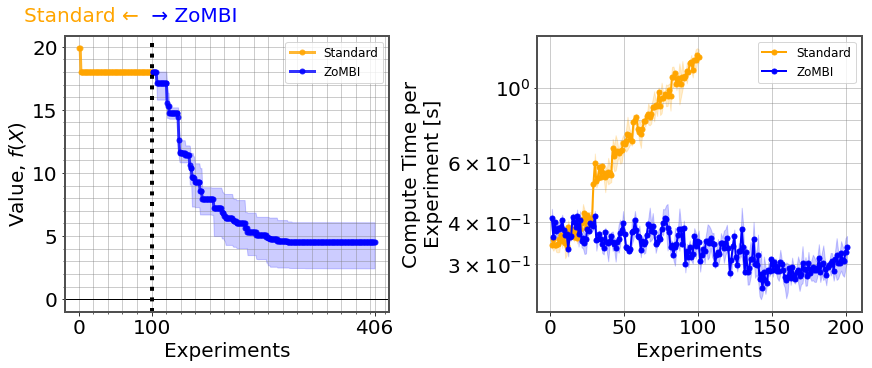

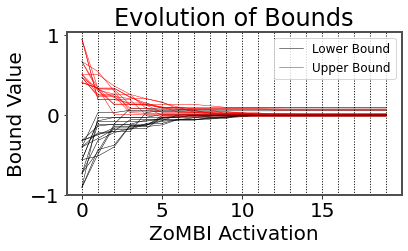

In [2]:
# Build analytical model
def ackley(x, b=0.5, a=20, c=2*np.pi, limit=15):
    """
    x: vector of input values
    """
    x = x.T * limit
    d = len(x) # dimension of input vector x
    sum_sq_term = -a * np.exp(-b * np.sqrt(sum(x*x) / d))
    cos_term = -np.exp(sum(np.cos(c*x) / d))
    return a + np.exp(1) + sum_sq_term + cos_term

# Construct dataset from model
dimensions = 5 # 5D Ackley function
lower = -1 *  np.ones((1, dimensions))[0] # -1 lower sampling bounds
upper = np.ones((1, dimensions))[0] # 1 upper sampling bounds
np.random.seed(123) # seed for repeatability
X_sample_norm = diversipy.polytope.sample(n_points=100000, lower=lower, upper=upper, thin=0) # X dataset with 100,000 datapoints
y_sample_mean = -1 * ackley(X_sample_norm) # fX dataset
X0 = diversipy.polytope.sample(n_points=5, lower=lower, upper=upper, thin=0) # initialization X dataset with 5 points
y0 = -1*ackley(X0) # initialization fX

# Run ZoMBI
zombi = ZoMBI(dataset_X = X_sample_norm, # X data
             dataset_fX = y_sample_mean, # fX data
             fX_model = ackley, # model to predict f(X) from X
             BO = EI_abrupt, # acquisition function options: LCB, EI, LCB_ada, EI_abrupt
             nregular = 100, # number of regular BO experiments before ZoMBI, reduce before running your own experiments
             activations = 20, # number of ZoMBI activations
             memory = 5, # number of memory points to retain per ZoMBI activation
             forward = 10, # number of forward experiments per ZoMBI activation
             ensemble = 3) # number of ensemble runs
zombi.optimize(X_initial = X0, fX_initial = y0, plot_f = True) # instantiate with initialization dataset

In [3]:
print(zombi.X, # .X grabs all X values
      zombi.fX_min) # .fX grabs running minimum fX values

[[ 2.90680817e-01  1.60873119e-01  1.29799434e-01  5.09145535e-01
   3.31060868e-01]
 [ 4.57085874e-01  7.51013040e-01 -1.60956820e-01  3.14081344e-01
   9.37275850e-01]
 [ 3.36286959e-01  3.02404451e-01 -1.15580692e-01 -1.19036290e-01
   1.91686778e-01]
 ...
 [-5.92025524e-04 -1.64232837e-02  4.16614662e-03 -1.91900916e-03
  -1.31389944e-04]
 [-5.92025524e-04 -1.64232837e-02  4.16614662e-03 -1.91900916e-03
  -1.31389944e-04]
 [-5.92025524e-04 -1.64232837e-02  4.16614662e-03 -1.91900916e-03
  -1.31389944e-04]] [[19.87766539 19.87766539 18.02735453 ...  6.19508957  6.19508957
   6.19508957]
 [19.87766539 19.87766539 18.02735453 ...  5.69070245  5.69070245
   5.69070245]
 [19.87766539 19.87766539 18.02735453 ...  1.63662411  1.63662411
   1.63662411]]


## Example 2: Negative Poisson's Ratio
#### Dataset obtained from [Materials Project](https://materialsproject.org/). Dataset is comprised of 146,323 materials and only ~1,192 or 0.81% of the total have a negative Poisson's ratio.

--------------------------------

##### X: {molecular density, atomic energy, Fermi energy, energy above hull, band gap}; f(X): {Poisson's Ratio)

##### Random Forest Regression with 500 trees is used to train the predictive model. The trained model is available for use as "poisson_RF_trained.pkl".

Ensemble 3, ZoMBI Activation 10 / 10 : [❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚❚        ] 10 / 10 experiments completed . . .                                    

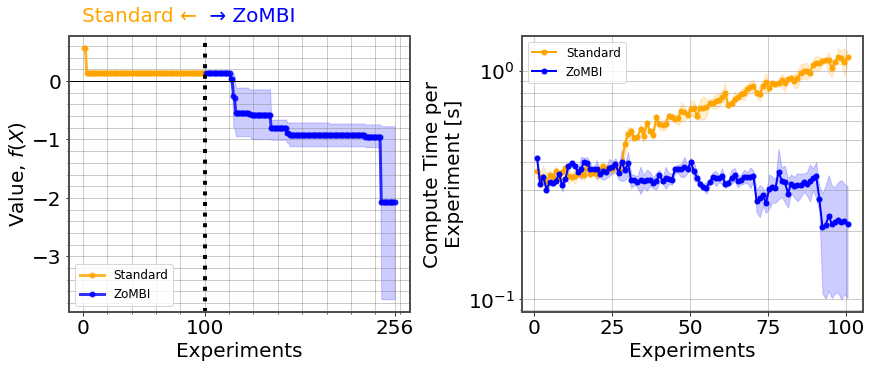

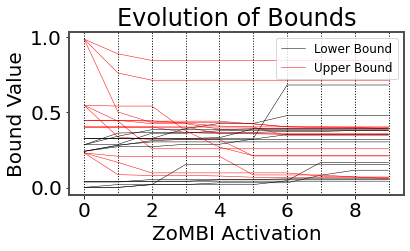

In [4]:
# Build the predictive model
poisson_model = joblib.load('./data/poisson/poisson_RF_trained.pkl') # load the trained model
poisson_model = poisson_model.predict # call the prediction function

# Construct dataset from model
dimensions = 5 # 5D X-dataset used to train the RF model
lower = np.zeros((1, dimensions))[0] # 0 lower sampling bounds
upper = np.ones((1, dimensions))[0] # 1 upper sampling bounds
np.random.seed(1) # seed for repeatability
X_sample_norm = diversipy.polytope.sample(n_points=100000, lower=lower, upper=upper, thin=0) # X dataset with 100,000 datapoints
y_sample_mean = -1 * poisson_model(X_sample_norm) # fX dataset
X0 = diversipy.polytope.sample(n_points=5, lower=lower, upper=upper, thin=0) # initialization X dataset with 5 points
y0 = -1 * poisson_model(X0) # initialization fX

# Run ZoMBI
zombi = ZoMBI(dataset_X = X_sample_norm, # X data
             dataset_fX = y_sample_mean, # fX data
             fX_model = poisson_model, # model to predict f(X) from X
             BO = LCB_ada, # acquisition function options: LCB, EI, LCB_ada, EI_abrupt
             nregular = 100, # number of regular BO experiments before ZoMBI, reduce before running your own experiments
             activations = 10, # number of ZoMBI activations
             memory = 5, # number of memory points to retain per ZoMBI activation
             forward = 10, # number of forward experiments per ZoMBI activation
             ensemble = 3) # number of ensemble runs
zombi.optimize(X_initial = X0, fX_initial = y0, plot_f = True) # instantiate with initialization dataset

In [5]:
print(zombi.X, # .X grabs all X values
      zombi.fX_min) # .fX grabs running minimum fX values

[[0.44513226 0.03257131 0.3783496  0.01147806 0.38115689]
 [0.45056618 0.02536138 0.35187191 0.0187253  0.3724651 ]
 [0.4025864  0.01950165 0.32618982 0.05310419 0.385059  ]
 ...
 [0.35732957 0.1499951  0.39476444 0.05833218 0.40329044]
 [0.35383243 0.1439112  0.39908135 0.05177159 0.3994929 ]
 [0.35383243 0.1439112  0.39908135 0.05177159 0.3994929 ]] [[ 0.56028856  0.55852165  0.13022359  0.13022359  0.13022359  0.13022359
   0.13022359  0.13022359  0.13022359  0.13022359  0.13022359  0.13022359
   0.13022359  0.13022359  0.13022359  0.13022359  0.13022359  0.13022359
   0.13022359  0.13022359  0.13022359  0.13022359  0.13022359  0.13022359
   0.13022359  0.13022359  0.13022359  0.13022359  0.13022359  0.13022359
   0.13022359  0.13022359  0.13022359  0.13022359  0.13022359  0.13022359
   0.13022359  0.13022359  0.13022359  0.13022359  0.13022359  0.13022359
   0.13022359  0.13022359  0.13022359  0.13022359  0.13022359  0.13022359
   0.13022359  0.13022359  0.13022359  0.13022359  0.1